In [0]:
!pip3 install keras
!pip3 install numpy
!pip3 install matplotlib
!pip3 install tqdm
!pip3 install opencv-python
!pip3 install glob2
!pip install PyDrive

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import time


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:

download = drive.CreateFile({'id': '1zHFL5CYKagVvyMe0U_BDqDVmGtT3NtC1'})
download.GetContentFile('Dogs.zip')

In [0]:
!unzip Dogs.zip


Archive:  Dogs.zip
replace __MACOSX/Dogs/._n02097658-silky_terrier? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
import os
import glob
count = 0
for e in glob.glob('Dogs/*/*'):
  count+=1
print(count)
IMG_NUM=count

20580


In [0]:
#Imports:
import cv2
%matplotlib inline
import matplotlib.pyplot as plt

#Dogs face detection imports:
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image             
from tqdm import tqdm
from keras.applications.resnet50 import preprocess_input, decode_predictions
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import glob

In [0]:
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

In [0]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

In [0]:
'''def createnp(path):
    data_path = path
    data_dir_list = os.listdir(data_path)
    
    img_data_list=[]

    for dataset in data_dir_list:
        #print(dataset)
        input_img=cv2.imread(data_path+'/'+ dataset)
        #print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
        #input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resize=cv2.resize(input_img,(224,224))
        #status = cv2.imwrite(f'cropped/{dataset}',input_img_resize)
        #print(input_img_resize.shape)
        img_data_list.append(input_img_resize)


    img_data = np.array(img_data_list)
    img_data = img_data.astype('float32')
    img_data = img_data/255
    return img_data
img_data = createnp('/content/drive/My Drive/dogs')
print(img_data.shape)'''
BATCH_SIZE = 100
EPOCH = 5


def createnp(path):
    print('generator initiated')
    img_data_list=[]
    count = 0
    while True:
      for img in glob.glob(path):
          input_img=cv2.imread(img)
          #input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
          input_img_resize=cv2.resize(input_img,(220,220))
          img_data_list.append(input_img_resize)
          count+=1
          if  len(img_data_list) == BATCH_SIZE:
            img_data_list = np.array(img_data_list)
            img_data_list = img_data_list.astype('float32')
            img_data_list = img_data_list/255
            yield img_data_list,img_data_list
            img_data_list = []
      if count==20500:
        break


In [0]:
import numpy as np
X = createnp('Dogs/*/*')
X_train, X_test = X,X
"""
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model"""

'''def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size, activation='relu'))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape), activation='sigmoid')) # np.prod(img_shape) is the same as 224*224*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder
    
IMG_SHAPE = (224,224,3)
encoder, decoder = build_autoencoder(IMG_SHAPE, 1000)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse', metrics=['accuracy'])

print(autoencoder.summary())'''

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, InputLayer
from keras.models import Model, Sequential
from keras import backend as K
def build_autoencoder():
  input_img = (220, 220,3)  # adapt this if using `channels_first` image data format
  encoder = Sequential()
  encoder.add(InputLayer(input_img))
  encoder.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
  encoder.add(MaxPooling2D((2, 2), padding='same'))
  encoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
  encoder.add(MaxPooling2D((2, 2), padding='same'))
  encoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
  encoder.add(MaxPooling2D((2, 2), padding='same'))

  # at this point the representation is (4, 4, 8) i.e. 128-dimensional
  vector_size = (28, 28, 8)
  decoder = Sequential()
  decoder.add(InputLayer(vector_size))
  decoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
  decoder.add(UpSampling2D((2, 2)))
  decoder.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
  decoder.add(UpSampling2D((2, 2)))
  decoder.add(Conv2D(16, (3, 3), activation='relu'))
  decoder.add(UpSampling2D((2, 2)))
  decoder.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))
  return encoder, decoder

encoder, decoder = build_autoencoder()
inp = Input(input_img)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse', metrics=['accuracy'])


print(autoencoder.summary())


"""
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])
print(autoencoder.summary())
"""



Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 220, 220, 3)       0         
_________________________________________________________________
sequential_19 (Sequential)   (None, 28, 28, 8)         2192      
_________________________________________________________________
sequential_20 (Sequential)   (None, 220, 220, 3)       2771      
Total params: 4,963
Trainable params: 4,963
Non-trainable params: 0
_________________________________________________________________
None


"\nautoencoder = Model(input_img, decoded)\nautoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])\nprint(autoencoder.summary())\n"

In [0]:
filepath='Checkpoint_{epoch:02d}_{val_loss:.2f}'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]


In [0]:
from keras.callbacks import TensorBoard
model = autoencoder.fit_generator(generator=X_train,
                                  steps_per_epoch=IMG_NUM//BATCH_SIZE,
                                  validation_data=X_test,
                                  validation_steps=IMG_NUM//BATCH_SIZE,
                                  epochs=60,
                                  shuffle=True,
                                  use_multiprocessing=True,
                                  callbacks=callbacks_list
                                  )

Epoch 1/60generator initiated

generator initiated

205/205 [==============================] - 167s 816ms/step - loss: 0.0249 - acc: 0.5766 - val_loss: 0.0116 - val_acc: 0.5486

Epoch 00001: val_loss improved from -inf to 0.01156, saving model to Checkpoint_01_0.01
Epoch 2/60
205/205 [==============================] - 162s 788ms/step - loss: 0.0107 - acc: 0.6233 - val_loss: 0.0102 - val_acc: 0.5771

Epoch 00002: val_loss did not improve from 0.01156
Epoch 3/60
205/205 [==============================] - 161s 783ms/step - loss: 0.0098 - acc: 0.6247 - val_loss: 0.0096 - val_acc: 0.5820

Epoch 00003: val_loss did not improve from 0.01156
Epoch 4/60
205/205 [==============================] - 161s 785ms/step - loss: 0.0092 - acc: 0.6260 - val_loss: 0.0089 - val_acc: 0.5919

Epoch 00004: val_loss did not improve from 0.01156
Epoch 5/60
205/205 [==============================] - 160s 779ms/step - loss: 0.0087 - acc: 0.6268 - val_loss: 0.0085 - val_acc: 0.6022

Epoch 00005: val_loss did not imp

In [0]:
from google.colab import files
encoder.save('Encoded_80.h5')
decoder.save('Decoded_80.h5')
files.download('Encoded_80.h5')
files.download('Decoded_80.h5')

In [0]:
import time

moment=time.localtime()
name='Model_perrete80.h5'
autoencoder.save(name)
files.download('Model_perrete80.h5')

In [0]:
'''model = autoencoder.fit_generator(generator=X_train,
                                  steps_per_epoch=IMG_NUM//BATCH_SIZE,
                                  validation_data=X_test,
                                  validation_steps=IMG_NUM//BATCH_SIZE,
                                  epochs=20,
                                  verbose=1,
                                  use_multiprocessing=True
                                  )'''

'model = autoencoder.fit_generator(generator=X_train,\n                                  steps_per_epoch=IMG_NUM//BATCH_SIZE,\n                                  validation_data=X_test,\n                                  validation_steps=IMG_NUM//BATCH_SIZE,\n                                  epochs=20,\n                                  verbose=1,\n                                  use_multiprocessing=True\n                                  )'

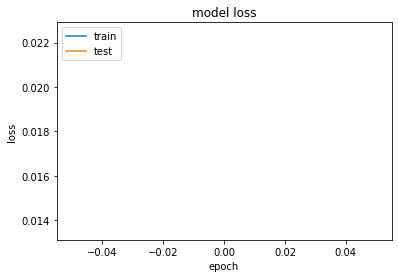

In [0]:
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
def createtest(path,limit):
    img_data_list=[]
    count = 0
    while True:
        for img in glob.glob(path):
            input_img=cv2.imread(img)
            #input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
            input_img_resize=cv2.resize(input_img,(220,220))
            img_data_list.append(input_img_resize)
            count+=1
            if  count == limit:
                img_data_list = np.array(img_data_list)
                img_data_list = img_data_list.astype('float32')
                img_data_list = img_data_list/255
                print(img_data_list.shape)
                return img_data_list
            
test = createtest('Dogs/*/*',100)

(100, 220, 220, 3)


In [0]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoded.predict(img[None])[0]
    reco = decoded.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco)
    plt.show()

for i in range(10):
    img = test[i]
    visualize(img,encoded,decoded)

NameError: ignored

In [0]:
name='Model_perroooo.h5'
model.save(name)

import json

model_json = model.to_json()
with open(name+'.json', "w") as json_file:
    json.dump(model_json, json_file)

model.save_weights(name+'.h5')

upload = drive.CreateFile({'title': name+'.json'})
upload.SetContentFile(name+'.json')
upload.Upload()
upload = drive.CreateFile({'title': name+'.h5'})
upload.SetContentFile(name+'.h5')
upload.Upload()

AttributeError: ignored

In [0]:
print(test.shape)
test = np.expand_dims(test, axis = 0)
print(test_4.shape)


(220, 220, 3)
(1, 220, 220, 3)


In [0]:
decoded_imgs = autoencoder.predict(test)

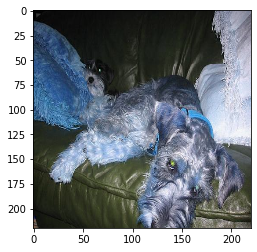

In [0]:
plt.imshow(test[1].reshape(220,220,3))

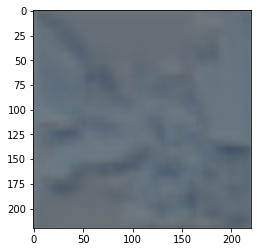

In [0]:
plt.imshow(decoded_imgs[1].reshape(220,220,3))